# Optimisation module
## CMA-ES algorithm
Optimisation of a function is performed by calling optim_CMA function in aduq.optim module

In [1]:
from math import pi

import numpy as np
import matplotlib.pyplot as plt

from aduq.optim import OptimResult, optim_CMA, optim_MH, CMA_optimiser

# Circle
angles = np.linspace(0, 2 * pi, 1000)
circle = np.array([np.cos(angles), np.sin(angles)]).T

# The two following functions are implemented for plotting purposes
def half_cov(cov):
    vals, vects = np.linalg.eigh(cov)
    return (np.sqrt(vals) * vects) @ vects.T

def repr_gauss(mean, cov, rad =1.0):
    loc_circle = circle.copy()
    return mean + rad * (loc_circle @ half_cov(cov))


# Define an optimisation objective: Rosenbrock
project_arr = np.array([1,0])
diff_arr = np.array([1, -1])
def score(x):
    """ Simple Rosenbrock like function to test optimisation """
    return (x @  project_arr - 2)** 2 + 100 * (x @ diff_arr)**2

# Define initial point
x0 = np.zeros(2)

# Launch optimisation routine
opt_res = optim_CMA(
    x0,
    score,
    chain_length=200, radius_ini=1.0, silent=True, cov_updt_speed=.4, keep_frac=.3, per_step=40,
    parallel=False, vectorized=True)

# The optimisation information is stored in an OptimResult object.
# The optimised parameter is stored in the opti_param attribute
opt_res.opti_param


array([2.00000001, 2.00000001])

CMA-ES routine works by drawing 'per_step' parameters at each optimisation step from a gaussian distribution centered on the best parameter found so far.

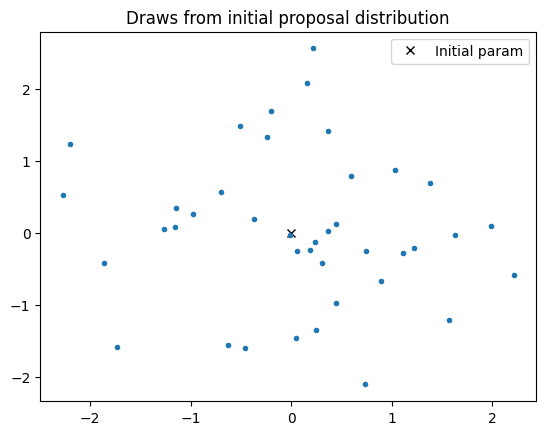

In [2]:
per_step = 40
cov_updt_speed = .4
ini_param = x0
ini_cov = opt_res.hist_cov[0]

points_0 = np.random.multivariate_normal(mean=ini_param, cov=ini_cov, size=per_step)

plt.plot(ini_param[0], ini_param[1], 'x', color="black", label='Initial param')
plt.plot(points_0[:,0], points_0[:, 1], '.')
plt.title("Draws from initial proposal distribution")
plt.legend()
plt.show()

The scores of each points are evaluated, and the future distribution is moved if a better parameter is found.

3.479724131748103


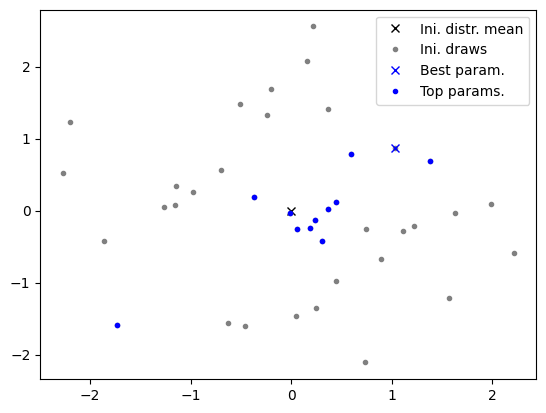

In [3]:
scores_0 = [score(point) for point in points_0]
sorter = np.argsort(scores_0)
best_index = sorter[0]
best_score, best_param = scores_0[best_index], points_0[best_index]

print(best_score)

# A fraction of points achieving good score is kept to update the covariance.
good_points = points_0[sorter[:int(per_step * .3)]]

plt.plot(ini_param[0], ini_param[1], 'x', color="black", label='Ini. distr. mean')
plt.plot(points_0[:,0], points_0[:, 1], '.', color="grey", label='Ini. draws')
plt.plot(best_param[0], best_param[1], 'x', color="blue", label="Best param.")
plt.plot(good_points[1:, 0], good_points[1:, 1], '.', color="blue", label="Top params.")
plt.legend()

The points achieving good score clearly indicate that good points lay in a specific direction. To sample preferentially in that direction, the covariance matrix is updated

Initial covariance:
[[1. 0.]
 [0. 1.]]
Updated covariance:
[[0.83258771 0.16154164]
 [0.16154164 0.75817938]]


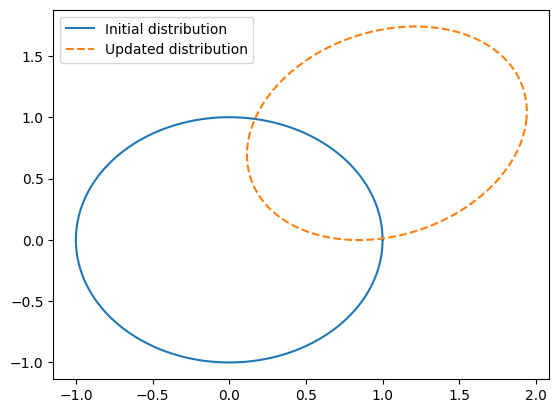

In [4]:
print(f"Initial covariance:\n{ini_cov}")

cov_updt = np.zeros((2,2))
for point in good_points:
    cov_updt = cov_updt + np.outer(point - ini_param, point - ini_param)
cov_updt = cov_updt / len(good_points)
cov = (1- cov_updt_speed) * ini_cov + cov_updt_speed * cov_updt

print(f"Updated covariance:\n{cov}")

# Schematically, the proposal distribution shifted in the following way
gauss0 = repr_gauss(ini_param, ini_cov)
gauss = repr_gauss(best_param, cov)
plt.plot(gauss0[:,0], gauss0[:, 1], "-", label="Initial distribution")
plt.plot(gauss[:,0], gauss[:, 1], "--", label="Updated distribution")

plt.legend()
plt.show()

Another mechanism put in place is covariance contraction.
Assuming that the scoring function can be differentiated, if the covariance radius is sufficiently small,
half of the draws should lower the score (as the gradient locally splits the space between lower/higher score through an hyperplane, and gaussian distributions are symmetric). If no draws lower the score, this implies with high probablity that the largest eigenvalue of the covariance is large enough to make the linear approximation of the score function fail. Contracting the covariance function will increase the probability of drawing parameters with lower scores, by looking closer to the current parameter.

To avoid contracting too often, the number of draws with score higher than the current minima before contracting should be reasonably high. This, as a guideline, should be at least higher than 10 (the probability of drawing 10 samples on one side of the hyperplane being less than 1/1000). Above 30 is safe. Note that the no_change_max argument counts draws and not optimisation steps.

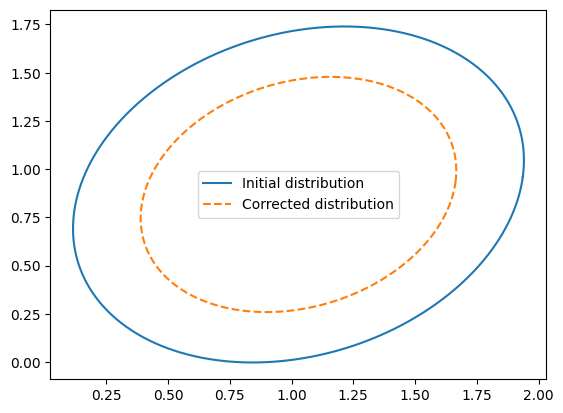

In [5]:
corr_radius = .7
gauss = repr_gauss(best_param, cov)
gauss_corr = repr_gauss(best_param, corr_radius ** 2 * cov) # Note the square!

plt.plot(gauss[:,0], gauss[:, 1], label="Initial distribution")
plt.plot(gauss_corr[:,0], gauss_corr[:, 1],  "--", label="Corrected distribution")
plt.legend()

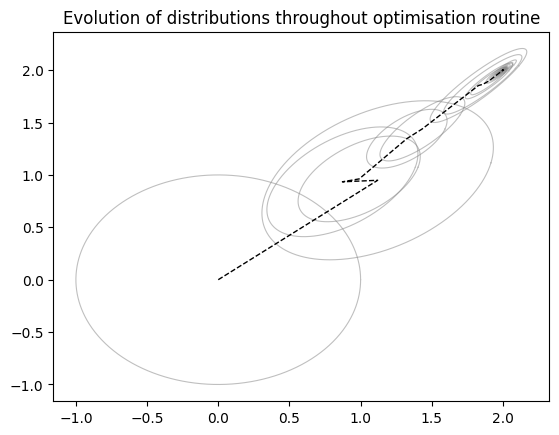

In [6]:
# We can represent the optimisation path for the initial task
for param, cov in zip(opt_res.hist_param, opt_res.hist_cov):
    gauss = repr_gauss(param, cov)
    plt.plot(gauss[:,0], gauss[:, 1], color="grey", alpha=.5, linewidth=.8)

params = np.array(opt_res.hist_param)

plt.plot(params[:, 0], params[:, 1],  '--', color="black", linewidth=1.0)
plt.title("Evolution of distributions throughout optimisation routine")
plt.show()

It is possible to recover the successive scores during the optimisation route to evaluate performance

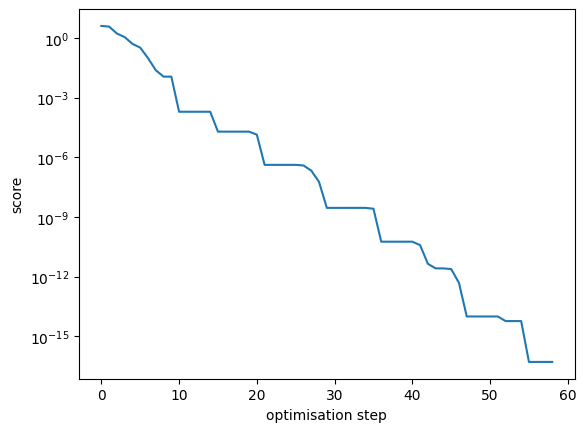

In [7]:
plt.plot(opt_res.hist_score)
plt.yscale("log")
plt.ylabel("score")
plt.xlabel("optimisation step")
plt.show()

Termination criteria are fixed by xtol and ftol. xtol is a condition on the covariance matrix. It stops when the square root of the highest diagonal element in the covariance matrix is smaller than xtol ** 2 (the square is for homogenity)
ftol is a condition on the evolution of the score. The learning speed, or decrease rate of the score, is measured by avering on the last 30 optimisation steps. If this speed is smaller than ftol, the optimisation stops.

The optimisation stops when the xtol or ftol criteria are met, or when the number of steps exceed chain_length.

A class for CMA optimisation is also implemented. Training is initiated using train

In [8]:
# A class for CMA optimisation is also proposed
optim = CMA_optimiser(par_ini=ini_param, cov_ini=ini_cov, radius_ini=1.0)
optim.train(50, score, 40, keep_frac=.3, print_rec=10, silent=True, vectorized=True)
optim.train(100, score, 40, keep_frac=.1, print_rec=10, silent=True, vectorized=True)


## Metropolis-Hastings based optimisation routine

The Metropolis-Hastings algorithm is implemented in a similar fashion. The difference with CMA-ES is that the covariance structure is not modified.
Only the covariance contracting procedure is used to draw appropriate samples.

Score at step 0: 4.0
New proposal radius: 0.7
New proposal radius: 0.48999999999999994
New proposal radius: 0.3429999999999999
New proposal radius: 0.24009999999999992
New proposal radius: 0.16806999999999994
New proposal radius: 0.11764899999999995
New proposal radius: 0.08235429999999996
Score at step 10: 0.001756487968658939
New proposal radius: 0.05764800999999997
New proposal radius: 0.04035360699999998
New proposal radius: 0.028247524899999984
New proposal radius: 0.019773267429999988
New proposal radius: 0.01384128720099999
New proposal radius: 0.009688901040699992
New proposal radius: 0.006782230728489994
New proposal radius: 0.004747561509942996
New proposal radius: 0.003323293056960097
Score at step 20: 1.636409732699276e-05
New proposal radius: 0.002326305139872068
New proposal radius: 0.0016284135979104473
New proposal radius: 0.001139889518537313
New proposal radius: 0.000797922662976119
New proposal radius: 0.0005585458640832833
New proposal radius: 0.00039098210485829826

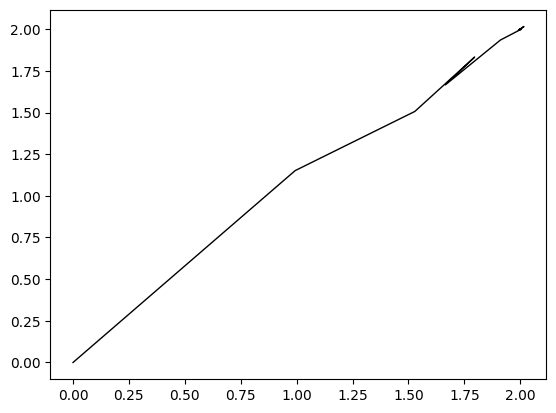

In [9]:
# Using optim_MH is similar to using optim_CMA
opt_res_MH = optim_MH(
    x0, score,
    chain_length=200, radius_factor=.7, radius_ini=1.0, silent=False, per_step=50,
    parallel=False, vectorized=True, print_rec=10)

# Access optimised parameter
print(f"Optimal param: {opt_res_MH.opti_param}")

# Plot parameter history
params = np.array(opt_res_MH.hist_param)

plt.plot(params[:,0], params[:, 1], color='black', linewidth=1.0)

If hyperparameters are well chosen, CMA-ES usually behaves better than MH. This is notably the case when the dimension increases.

Optimisation algorithm did not converge


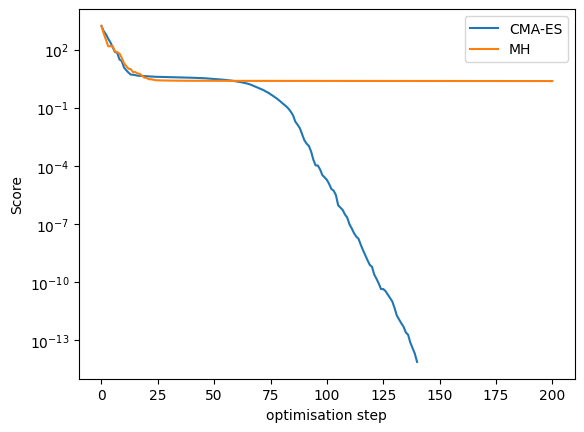

In [10]:
dim = 15

def score(x):
    """ Simple Rosenbrock like function to test optimisation """
    return (x[0] - 2)** 2 + 100 * np.sum((x[:-1]-x[1:])**2)

# Define initial point
x0 = np.random.normal(0,1, dim)

# Launch optimisation routine
opt_res_CMA = optim_CMA(x0, score, chain_length=200, radius_ini=1.0, radius_factor=.8, silent=True, cov_updt_speed=.25, keep_frac=.2, per_step=1000, parallel=False)
opt_res_MH = optim_MH(x0, score, chain_length=200 ,radius_ini=1.0, radius_factor=.8, silent=True, per_step=1000, parallel=False)

plt.plot(opt_res_CMA.hist_score, label='CMA-ES')
plt.plot(opt_res_MH.hist_score, label="MH")
plt.yscale("log")
plt.ylabel("Score")
plt.xlabel("optimisation step")
plt.legend()
plt.show()

### Is optim_CMA a global or local optimisation technique?

The rationale behind the covariance contraction part of optim_CMA is based on the score gradient, hinting that optim_CMA may be a gradient minded gradient-free optimisation method, and as such, a local optimisation technique. However, the inherent randomness of the algorithm makes it possible that the global minimiser may be found, even if the initial parameter rests at a local minima. We assess that probability in an exemple below

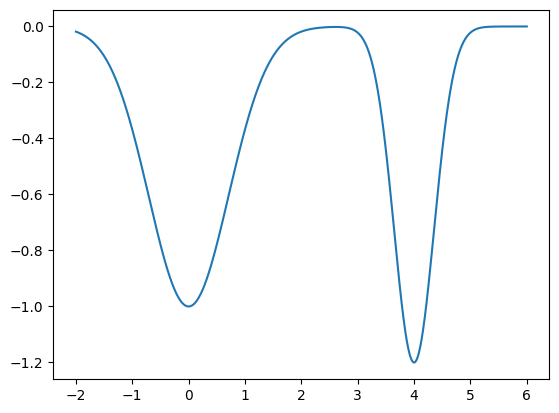

In [11]:
# We consider a one dimensional problem
import numpy as np
import matplotlib.pyplot as plt

def score(x):
    return -(1.2 * np.exp(- 4 * (x @ [1]- 4) **2) + 1.0 * np.exp(-1.0 * (x @ [1])**2))

xs = np.linspace(-2, 6, 1000).reshape([1000, 1])
ys = score(xs)
plt.plot(xs, ys)

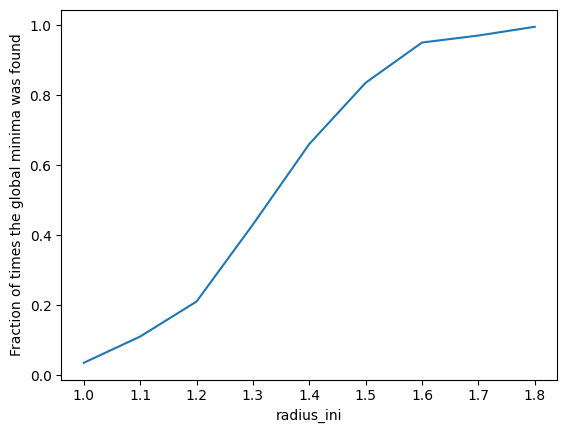

In [12]:
# We start the optimisation close to a local minima (at 0) and assess how many times the global minimas is found
# This is highly sensitive to the hyperparameters

scores_accu =[
    np.mean(
        np.array(
            [
                optim_CMA(np.array([0]), radius_ini=x, n_average_speed =15, score=score, silent=True, ftol=10**-6, vectorized=True).opti_score for _ in range(200)
                ]
        ) < -1.15
    ) for x in [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
        ] 

plt.plot([1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8], scores_accu)
plt.xlabel("radius_ini")
plt.ylabel("Fraction of times the global minima was found")
plt.show()